In [12]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [35]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,33248,None,None,85801.889523
2020-06-13,33249,None,None,79715.224717
2020-06-14,33250,None,None,74061.836205
2020-06-15,33251,None,None,68736.111083
2020-06-16,33252,None,None,63992.890996
...,...,...,...,...
2021-02-19,33500,None,None,179005.354882
2021-02-20,33501,None,None,173009.500955
2021-02-21,33502,None,None,167904.832311


In [36]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-02-23_2021-02-23-19-20.pickle


In [37]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-02-22_2021-02-22-16-42.pickle


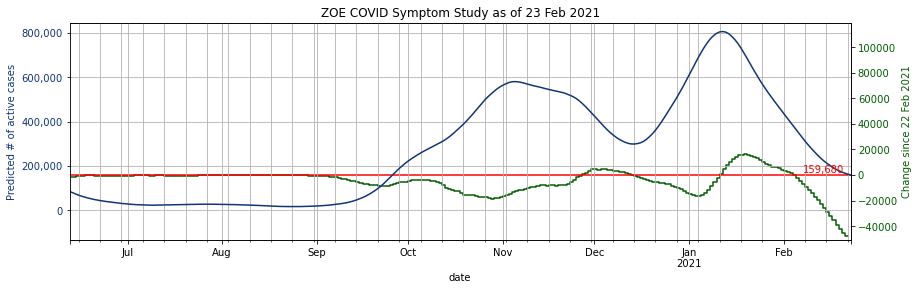

In [38]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

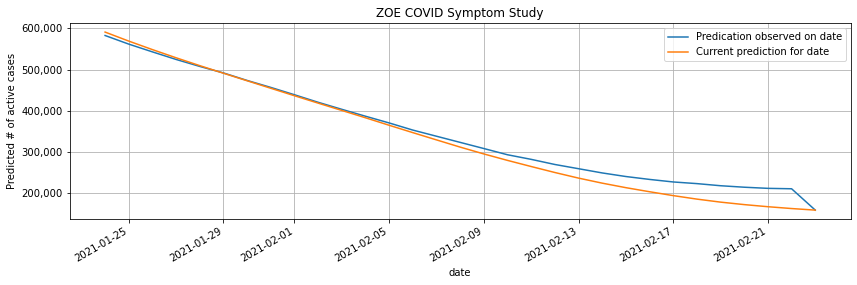

In [39]:
plot_study_evolution(curr_date, days=30)

In [40]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [41]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-02-23_2021-02-23-19-20.pickle


In [42]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
299,Wolverhampton,E08000031,1.092327
53,Havant,E07000090,1.084438
25,Leicester,E06000016,0.862927
4,Darlington,E06000005,0.703281
124,Harlow,E07000073,0.685254
151,Blaby,E07000129,0.675366
386,Newport,W06000022,0.643733
280,Doncaster,E08000017,0.639576
258,Redditch,E07000236,0.634675
327,Gwynedd,W06000002,0.633990
